# Back to Newton iterators. . .

We will continue the exploration from the Monday class and the labs. 

Let's start with adding the points of failure to our basins of attraction plot.  

First, we cut-and-paste our code from Monday. 


In [1]:
import sympy as sp
import numpy as np
import math as ma
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib nbagg

expaths = ["/usr/lib/python3/dist-packages", "/usr/local/lib/python3.5/dist-packages"]
for xp in expaths:
    if (xp not in sys.path):
        sys.path.append(xp)
import tqdm
from sympy.utilities.autowrap import ufuncify

x,y = sp.symbols("x y", real=True)
sol = sp.solve([x**3 - 3*x*y**2 - 1, 3*x**2*y-y**3 ])
#sp.pprint(sol)

solf = []
for S in sol:
    print('x == ', S[x].evalf(), ' ', end='')
    print('y == ', S[y].evalf(), ' ')
    solf.append( (S[x].evalf(), S[y].evalf()) )
solf = np.array(solf)

f = sp.Matrix([x**3 - 3*x*y**2 - 1, 3*x**2*y-y**3 ])
#print("f == ")
#sp.pprint(f)
Df = sp.Matrix([f.diff(x).T, f.diff(y).T]).T
#sp.pprint(Df)
x0, y0 = sp.symbols('x_0 y_0')
#print("Df using x_0, y_0")
Df = Df.subs([(x,x0), (y,y0)])
#sp.pprint(Df)

NIT = sp.Matrix([x0, y0]) - (Df**-1)*(f.subs([(x,x0), (y,y0)]))
NIT.simplify()
#print("Newton iterator.")
#sp.pprint(NIT)


nit = []
for i in range(2):
    nit.append(ufuncify([x0,y0], NIT[i,0]) )

nitv = lambda x,y: np.array([nit[0](x,y), nit[1](x,y)])

## and the determinant of the derivative
## we will use this as an abort criterion for Newton's method.
ddf = ufuncify([x0,y0], Df.det())

x ==  -0.500000000000000  y ==  -0.866025403784439  
x ==  -0.500000000000000  y ==  0.866025403784439  
x ==  1.00000000000000  y ==  0  


In [2]:
## colors for the 4 roots, and one for a failed algorithm
cList = [[1.0,1.0,1.0], [1.0, 0.2, 0.2], [0.2, 1.0, 0.2], [0.2, 0.2, 1.0], [0.0, 0.0, 0.0]]

## routine to run Newton's method with a given initial condition. 
## returns the appropriate color from cList, depending on the root found, 
## or if the routine aborts. 

## z0 is the initial value, it will be a numpy pair z0 = [x0,y0]
## n is the number of iterations we allow before we abort.
def newtit( z0, n ):
    retval = cList[-1]
    for i in range(n):
        ## check to see how close we are to roots. . .
        droot = []
        for i in range(solf.shape[0]):
            dif = solf[i]-z0
            droot.append( ( ma.sqrt(sum(dif*dif)), i ) )
            
        droot = sorted(droot)
        if droot[0][0]<0.000001:
            retval = cList[droot[0][1]]
            break
            
        ## if not close, check to see if Det(Df) is too small
        if abs(ddf(*z0))<0.000001:
            break
            
        ## if not, iterate. 
        z0 = nitv(*z0)
    
    return retval

In [4]:
## routine to generate picture.

xarr = np.linspace(-3.0, 3.0, 900)
yarr = np.linspace(-3.0, 3.0, 900)

img = []

#for y in yarr:
for j in tqdm.tqdm(range(yarr.shape[0])):
    y = yarr[j]
    bline = []
    for x in xarr:
        bline.append( newtit( (x,y), 200 ) )
    img.append(bline)
    

100%|██████████| 900/900 [57:10<00:00,  4.45s/it]


<IPython.core.display.Javascript object>


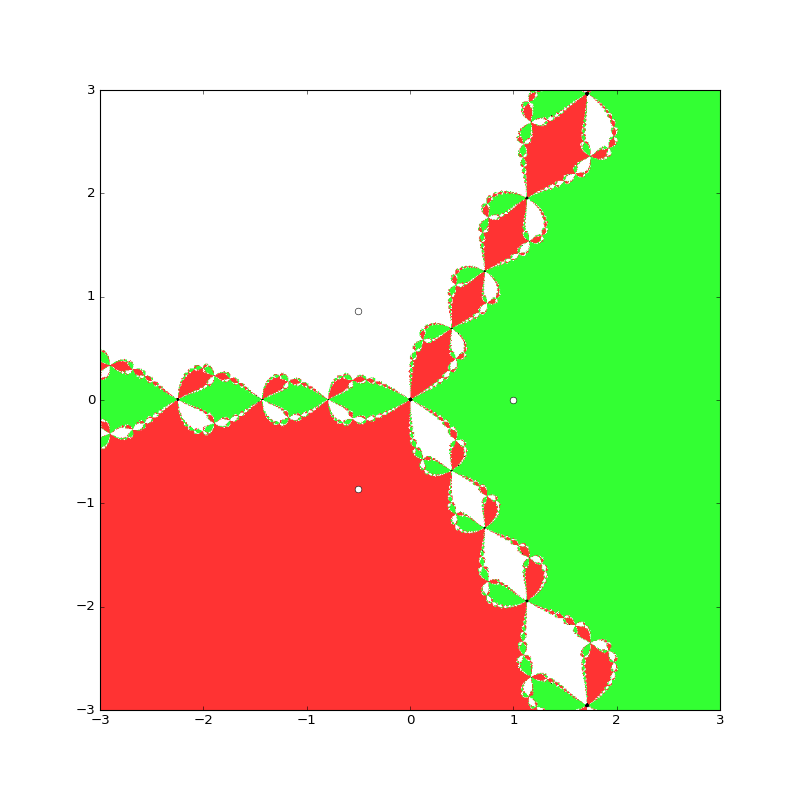

In [5]:
plt.close()

fig, ax = plt.subplots(figsize=(10,10))

plt.plot( [r[0] for r in solf], [r[1] for r in solf], 'wo')

implot = plt.imshow( img, extent=[-3,3,-3,3], aspect=1.0 )

## And now, let's find the points of failure

Let's review Newton's method from the complex-variable perspective.  Our function is

$$f(z) = z^3 - 1$$

Newton's method is to solve for $L(z)=0$ where $L(z)$ is the linear approximation at the previous estimate for the root, $z_0$. 

$$L(z) = f(z_0) + Df_{z_0}(z-z_0) $$

With some algebra we see solving the equation $L(z)=0$ is equivalent to:

$$z_0^3 - 1 + 3z_0^2(z-z_0) = 0$$

. . . which gives, 

$$ z = z_0 + \frac{1-z_0^3}{3z_0^2} $$

So we call $N(z) = z + \frac{1-z^3}{3z^2}$ the **Newton iterator**. 

Clearly the Newton iterator is undefined only at $z=0$.   So we define

$$F_1 = \{ 0 \} $$

as the points of failure, in one step.  We let $F_2$ be the points that fail in two iterations of the Newton iterator, i.e. $z \in F_2$ means $N(z) \in F_1$.  In general, $z \in F_n$ means $N(z) \in F_{n-1}$. 

We set up the problem of *solving* for the points in $F_n$ recursively.  Since $F_1 = \{0\}$ we know $z \in F_2$ means that $N(z) = 0$, i.e. 

$$0 = z + \frac{1-z^3}{3z^2}$$

$$0 = 3z^3 + 1 -z^3 = 2z^3 + 1$$

which we could solve with the [**numpy.roots**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html) command, or sympy's [**sympy.polys.polytools.nroots**](http://docs.sympy.org/dev/modules/polys/reference.html) command. 

More generally, we need to solve

$$N(z) \in F_{n-1}$$

to find $z_n \in F_n$. 

i.e. 

$$ z + \frac{1-z^3}{3z^2} \in F_{n-1} $$

if we denote an element of $F_{n-1}$ by $z_{n-1}$ we are solving for

$$ z + \frac{1-z^3}{3z^2} = z_{n-1} $$

equivalently, 

$$ 3z^3 + 1-z^3 = 3z_{n-1}z^2 $$

$$ 2z^3 -3z_{n-1}z^2 + 1 = 0$$

which we can solve with **numpy.roots**, or **sympy.polys.polytools.nroots**. 

In [6]:
## Let'd do it.  A routine to iteratively compute the sets F_n.  

## a list of sets FS[n] will be F_{n+1} described above, i.e. FS[0] = {0}, 
## FS[1] = roots of 2z^3 + 1 = 0, etc. 
FS = [ [0.0+0.0j] ]

## FS[0] is F_1
## FS[k] is F_{k+1}

## complex floating point numbers are represented as
##  float + floatj
##  1.0 + 2.0j "complex number 1+2i" do not use * 
def buildFS():
    global FS
    newroots = []
    for zk in FS[-1]:
        p = [2.0, -3*zk, 0.0, 1.0] ## numpy poly convention
        for zi in np.roots(p):
            newroots.append(zi)
    FS.append(newroots)
    

In [7]:
while len(FS[-1])<10000:
    buildFS()
print(len(FS[-1]))
print(len(FS))

19683
10


<IPython.core.display.Javascript object>


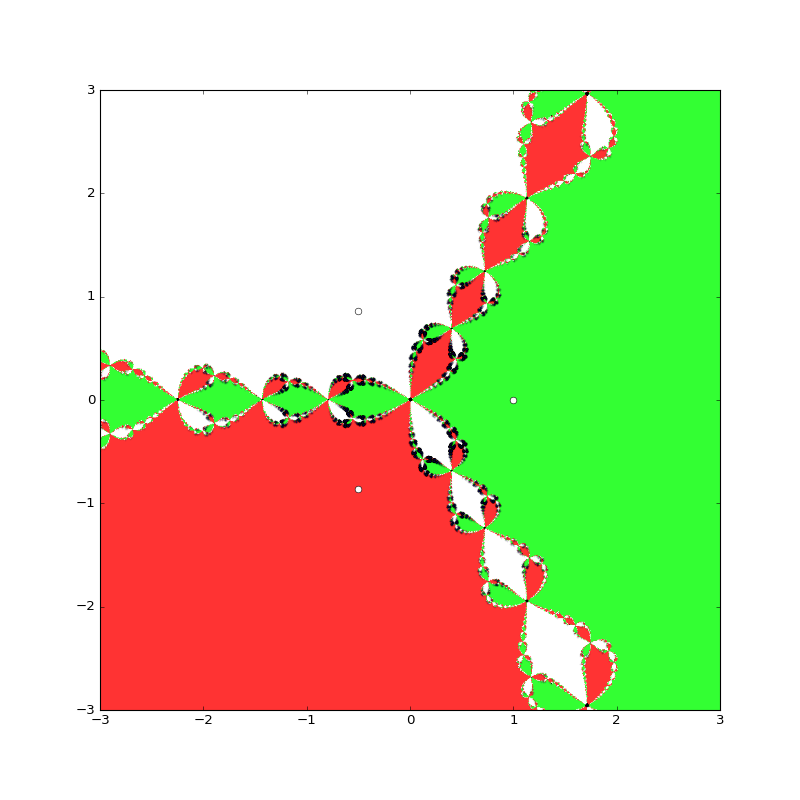

In [8]:
plt.close()
## FS is a list of lists, and we want to plot **all** the elements in this list of lists.
## we want to "flatten" this list
flatFS = sum(FS, []) ## flatten
flatFS = np.array(flatFS) ## converts to numpy array

fig, ax = plt.subplots(figsize=(10,10))

plt.plot( [r[0] for r in solf], [r[1] for r in solf], 'wo')

plt.scatter( np.real(flatFS), np.imag(flatFS), alpha = 0.1, s=0.5, c='b')

implot = plt.imshow( img, extent=[-3,3,-3,3], aspect=1.0 )

### Newton's method can fail in other ways. . .

In the case of polynomial root finding, it's an interesting fact that there is only two modes of failure of Newton's method:

 1) The *catastrophic failure* of the Newton iterator being undefined, which we explored in the previous plot.  
 
 2) The less dramatic failure, or Newton's method iterating forever and not finding the root.  For polynomial root finding, it's an interesting fact that this only happens for **periodic** orbits.  This is a sequence of points that repeats:
 
 $$z_0 \longmapsto N(z_0) \longmapsto N^{(2)}(z_0) \longmapsto \cdots \longmapsto N^{(k)}(z_0) = z_0 $$
 
 The minimal integer $k\geq 1$ is called the **period** of the orbit.  Period one points are called **fixed points** of the iterator, etc. 
 
 We will write some code to find these periodic orbits, below. 

We are looking for solutions to the equation

$$N^{(k)}(z) = z$$

with $N(z) = z + \frac{1-z^3}{3z^2}$. 

Perhaps before we attack this 'head on' we should make some partial attempts at it.  First off, what might be an efficient way to compute $N^{(k)}(z)$? 

Let's try in Sympy. 

In [10]:
z = sp.Symbol('z')
f = z + (1-z**3)/(3*z**2)
sp.pprint(f)

## N^{(2)} denote f2
f2 = sp.expand(sp.simplify(f.subs(z, f)))
#sp.pprint(f2)

f3 = sp.expand(sp.simplify(f2.subs(z,f)))
#sp.pprint(f3)

       3    
    - z  + 1
z + ────────
         2  
      3⋅z   


### A problem!

One can not write down nice closed-form descriptions of the roots of high-degree polynomials, thus Sympy fails. 

Another interesting feature is that, in our set up, points of period 1 are automatically considered points of period 2 -- we have not written any code to ensure the cycle is *shortest possible*.  

We can perhaps use this to our advantage.  

### A pattern emerges

We see a nice pattern developing. The function $f^{(k)}(z)$ we can apparently always write as

$$f^{(k)}(z) = \frac{p_k(z)}{q_k(z)}$$

where $p_k(z)$ and $q_k(z)$ are polynomials with (apparently) integer coefficients.  Let's see if we can solve for these polynomials efficiently. 

If $f^{(k-1)}(z) = \frac{p_{k-1}(z)}{q_{k-1}(z)}$ then
$$f^{(k)}(z) = f(f^{(k-1)}(z)) = \frac{ 2\left( \frac{p_{k-1}(z)}{q_{k-1}(z)}\right)^3 + 1}{3 \left(\frac{p_{k-1}(z)}{q_{k-1}(z)}\right)^2}$$
which if we multiply-through by $q_{k-1}(z)^3$ gives

$$f^{(k)}(z) = \frac{2p_{k-1}(z)^3 + q_{k-1}(z)^3}{3p_{k-1}(z)^2 \cdot q_{k-1}(z) }$$
which gives us the recursion

$$p_k(z) = 2p_{k-1}(z)^3 + q_{k-1}(z)^3 \hskip 1cm q_k(z) = 3p_{k-1}(z)^2 \cdot q_{k-1}(z)$$
with
$$p_0(z) = z \hskip 1cm q_0(z) = 1$$

moreover, periodic points of period $k$ are ones where

$$f^{(k)}(z) = z$$

i.e. 

$$p_k(z) - z q_k(z) = 0$$

This is a polynomial equation, which we can solve with the **numpy.roots** or **sympy.polys.polytools.nroots** command. 

In [11]:
## use sympy to start
z = sp.Symbol('z')
## one of sympy's polynomial primitive objects
## coeffs are first argument largest to smallest, last arg "z" variable name
zp = sp.Poly([1,0], z)

p = [zp]
q = [sp.Poly([1], z)]

def buildparr():
    global p
    global q
    op = p[-1]
    oq = q[-1]
    p.append(2*op**3 + oq**3)
    q.append(3*(op**2)*oq )

In [13]:
while len(p)<8:
    buildparr()
print(len(p))

8


In [14]:
print("Period 1 points: ")
sp.pprint( sp.solve( p[1]-zp*q[1] ) )
## periodic points of period 1 are the original roots.

Period 1 points: 
⎡     1   √3⋅ⅈ    1   √3⋅ⅈ⎤
⎢1, - ─ - ────, - ─ + ────⎥
⎣     2    2      2    2  ⎦


In [15]:
## technically these are all solutions to 
## f^{(2)}(z) = z
## period one pts are roots of p[1]-zp*q[1]
pol2, rem2 = sp.div( p[2]-zp*q[2], p[1]-zp*q[1], z)

#sp.pprint(pol2)
#sp.pprint(rem2)

print("Period 2 points: ")
sp.pprint( sp.solve( pol2 ) )
## could get float using evalf but
## we will see sympy will choke for k==3.

Period 2 points: 
⎡         ⎛      ⎛3⋅√15⎞    ⎞              ⎛      ⎛3⋅√15⎞    ⎞           ⎛    
⎢         ⎜  atan⎜─────⎟    ⎟              ⎜  atan⎜─────⎟    ⎟           ⎜  at
⎢  5/6    ⎜      ⎝  5  ⎠   π⎟     5/6      ⎜      ⎝  5  ⎠   π⎟    5/6    ⎜    
⎢10   ⋅cos⎜- ─────────── + ─⎟   10   ⋅ⅈ⋅sin⎜- ─────────── + ─⎟  10   ⋅cos⎜- ──
⎢         ⎝       3        3⎠              ⎝       3        3⎠           ⎝    
⎢──────────────────────────── - ──────────────────────────────, ──────────────
⎣             10                              10                             1

  ⎛3⋅√15⎞    ⎞              ⎛      ⎛3⋅√15⎞    ⎞             ⎛      ⎛3⋅√15⎞    
an⎜─────⎟    ⎟              ⎜  atan⎜─────⎟    ⎟             ⎜  atan⎜─────⎟    
  ⎝  5  ⎠   π⎟     5/6      ⎜      ⎝  5  ⎠   π⎟      5/6    ⎜      ⎝  5  ⎠   π
───────── + ─⎟   10   ⋅ⅈ⋅sin⎜- ─────────── + ─⎟    10   ⋅cos⎜- ─────────── + ─
   3        3⎠              ⎝       3        3⎠             ⎝       3        3
────────────── + ────────────────

In [16]:
pol3, rem3 = sp.div( p[3]-zp*q[3], p[1]-zp*q[1], z)
print("Period 3 points: ")
sp.pprint( sp.solve( pol3 ))

Period 3 points: 
⎡       ⎛    6      3       ⎞         ⎛    6      3       ⎞         ⎛    6    
⎣CRootOf⎝19⋅z  + 7⋅z  + 1, 0⎠, CRootOf⎝19⋅z  + 7⋅z  + 1, 1⎠, CRootOf⎝19⋅z  + 7

  3       ⎞         ⎛    6      3       ⎞         ⎛    6      3       ⎞       
⋅z  + 1, 2⎠, CRootOf⎝19⋅z  + 7⋅z  + 1, 3⎠, CRootOf⎝19⋅z  + 7⋅z  + 1, 4⎠, CRoot

  ⎛    6      3       ⎞         ⎛      18         15         12         9     
Of⎝19⋅z  + 7⋅z  + 1, 5⎠, CRootOf⎝1024⋅z   + 4800⋅z   + 8484⋅z   + 4018⋅z  + 12

    6       3        ⎞         ⎛      18         15         12         9      
57⋅z  + 84⋅z  + 16, 0⎠, CRootOf⎝1024⋅z   + 4800⋅z   + 8484⋅z   + 4018⋅z  + 125

   6       3        ⎞         ⎛      18         15         12         9       
7⋅z  + 84⋅z  + 16, 1⎠, CRootOf⎝1024⋅z   + 4800⋅z   + 8484⋅z   + 4018⋅z  + 1257

  6       3        ⎞         ⎛      18         15         12         9        
⋅z  + 84⋅z  + 16, 2⎠, CRootOf⎝1024⋅z   + 4800⋅z   + 8484⋅z   + 4018⋅z  + 1257⋅

 6       3        ⎞         

In [17]:
## we need to find the floating point roots, we don't need closed form
import sympy.polys.polytools as spp

## numpy verion of polynomial
POL2 = [int(x) for x in spp.Poly.all_coeffs(pol2)]
PER2 = np.roots(POL2)
print(PER2)

[ 0.53860867+0.41720448j  0.53860867-0.41720448j  0.09200535+0.67505103j
  0.09200535-0.67505103j -0.63061402+0.25784655j -0.63061402-0.25784655j]


In [18]:
POL3 = [int(x) for x in spp.Poly.all_coeffs(pol3)]
PER3 = np.roots(POL3)
print(PER3)

[-1.32285339+0.24174516j -1.32285339-0.24174516j  0.45206925+1.26649722j
  0.45206925-1.26649722j  0.87078414+1.02475207j  0.87078414-1.02475207j
 -0.70948904+0.22635599j -0.70948904-0.22635599j -0.59835789+0.12932137j
 -0.59835789-0.12932137j -0.44061505+0.23478311j -0.44061505-0.23478311j
  0.15871448+0.72761352j  0.15871448-0.72761352j  0.55077455+0.50125753j
  0.55077455-0.50125753j  0.01697939+0.49897538j  0.01697939-0.49897538j
  0.18718335+0.58285381j  0.18718335-0.58285381j  0.41117453+0.45353245j
  0.41117453-0.45353245j  0.42363566+0.26419227j  0.42363566-0.26419227j]


In [19]:
pol4, rem4 = sp.div( p[4]-zp*q[4], (p[2]-zp*q[2]), z)
print("Period 4 points: ")
print(rem4)

POL4 = [int(x) for x in spp.Poly.all_coeffs(pol4)]
PER4 = np.roots(POL4)
print(PER4)
print(type(PER4))

Period 4 points: 
Poly(0, z, domain='ZZ')
[ -2.15485369e+00+0.28179419j  -2.15485369e+00-0.28179419j
   8.33385916e-01+2.00705514j   8.33385916e-01-2.00705514j
   1.32146778e+00+1.72526094j   1.32146778e+00-1.72526094j
  -1.36836298e+00+0.20601206j  -1.36836298e+00-0.20601206j
   5.05769812e-01+1.28804313j   5.05769812e-01-1.28804313j
   8.62593167e-01+1.08203107j   8.62593167e-01-1.08203107j
  -1.21853203e+00+0.1375491j   -1.21853203e+00-0.1375491j
  -1.09986823e+00+0.21151796j  -1.09986823e+00-0.21151796j
   4.90145003e-01+1.12405425j   4.90145003e-01-1.12405425j
   7.28387030e-01+0.98650515j   7.28387030e-01-0.98650515j
   3.66754188e-01+1.05827281j   3.66754188e-01-1.05827281j
   7.33114044e-01+0.84675485j   7.33114044e-01-0.84675485j
  -7.45881201e-01+0.18859557j  -7.45881201e-01-0.18859557j
   2.09612043e-01+0.74024985j   2.09612043e-01-0.74024985j
   5.36269158e-01+0.55165428j   5.36269158e-01-0.55165428j
  -6.37481171e-01+0.20029734j  -6.37481171e-01-0.20029734j
  -6.24183297e-

In [20]:
pol5, rem5 = sp.div( p[5]-zp*q[5], (p[1]-zp*q[1]), z)
print("Period 5 points: ")
print(rem5)

POL5 = [int(x) for x in spp.Poly.all_coeffs(pol5)]
PER5 = np.roots(POL5)
print(PER5)
print(type(PER5))

Period 5 points: 
Poly(0, z, domain='ZZ')
[-3.33042119+0.34344734j -3.33042119-0.34344734j  1.96264471+2.71250568j
  1.96264471-2.71250568j  1.36777647+3.05595302j  1.36777647-3.05595302j
 -2.19117035+0.23503342j -2.19117035-0.23503342j  0.89204027+2.0151259j
  0.89204027-2.0151259j   1.29913008+1.78009248j  1.29913008-1.78009248j
 -1.94838544+0.19153066j -1.94838544-0.19153066j -1.82371504+0.27068382j
 -1.82371504-0.27068382j  0.80832229+1.78311661j  0.80832229-1.78311661j
  1.14006313+1.59158594j  1.14006313-1.59158594j  0.67743846+1.71472546j
  0.67743846-1.71472546j  1.14627657+1.44404164j  1.14627657-1.44404164j
 -1.39381057+0.17098952j -1.39381057-0.17098952j  0.84515176+1.12178765j
  0.84515176-1.12178765j  0.54883076+1.29270205j  0.54883076-1.29270205j
  0.79488257+1.02975782j  0.79488257-1.02975782j  0.70811021+1.09272335j
  0.70811021-1.09272335j  0.84433773+0.95099195j  0.84433773-0.95099195j
  0.81844500+0.9674283j   0.81844500-0.9674283j   0.58957061+1.15384826j
  0.589570

In [24]:
pol6, rem6 = sp.div( (p[6]-zp*q[6])*(p[1]-zp*q[1]), (p[3]-zp*q[3])*(p[2]-zp*q[2]), z)
print(rem6)

print("Period 6 points: ")

POL6 = [int(x) for x in spp.Poly.all_coeffs(pol6)]
PER6 = np.roots(POL6)
print(PER6)


Poly(0, z, domain='ZZ')
Period 6 points: 
[  2.89683824e+00 +4.17327385e+00j   2.89683824e+00 -4.17327385e+00j
   2.16591733e+00 +4.59531974e+00j   2.16591733e+00 -4.59531974e+00j
  -5.06244495e+00 +4.21973158e-01j  -5.06244495e+00 -4.21973158e-01j
   1.57904489e+00 +3.12801204e+00j   1.57904489e+00 -3.12801204e+00j
   2.01002478e+00 +2.84433146e+00j   2.01002478e+00 -2.84433146e+00j
  -3.49107702e+00 +0.00000000e+00j  -3.38411903e+00 +4.01618301e-01j
  -3.38411903e+00 -4.01618301e-01j   1.22531893e+00 +3.05650369e+00j
   1.22531893e+00 -3.05650369e+00j   2.01369208e+00 +2.45909795e+00j
   2.01369208e+00 -2.45909795e+00j  -3.00920809e+00 +5.55317269e-01j
  -3.00920809e+00 -5.55317269e-01j   9.40699986e-01 +2.80044176e+00j
   9.40699986e-01 -2.80044176e+00j   1.90610813e+00 +2.13288394e+00j
   1.90610813e+00 -2.13288394e+00j  -2.68999090e+00 +5.75811831e-01j
  -2.68999090e+00 -5.75811831e-01j   7.91130259e-01 +2.52176519e+00j
   7.91130259e-01 -2.52176519e+00j   1.73332712e+00 +1.877157

<IPython.core.display.Javascript object>


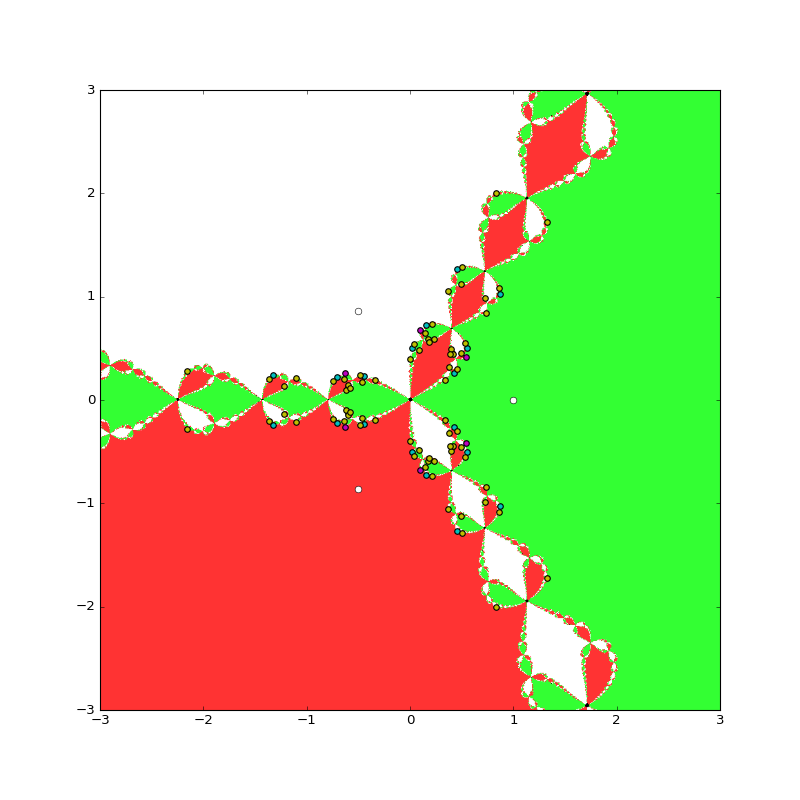

In [28]:
plt.close()

fig, ax = plt.subplots(figsize=(10,10))

plt.plot( [r[0] for r in solf], [r[1] for r in solf], 'wo')

#plt.scatter( np.real(flatFS), np.imag(flatFS), alpha = 0.1, s=0.5, c='b')

plt.scatter( np.real(PER2), np.imag(PER2), s=25.0, c='m')
plt.scatter( np.real(PER3), np.imag(PER3), s=25.0, c='c')
plt.scatter( np.real(PER4), np.imag(PER4), s=25.0, c='y')
#the period 5 and period 6 points in PER5 and PER6 are clearly wrong!
# we've broken numpy by asking too much of its root-solving algorithm.

#plt.scatter( np.real(PER5), np.imag(PER5), s=25.0, c='b')
#plt.scatter( np.real(PER6), np.imag(PER6), s=25.0, c='w')

implot = plt.imshow( img, extent=[-3,3,-3,3], aspect=1.0 )

### How does the newton iterator behave near periodic points?

If $z_0$ is a point of period $k$ is compute

$$D(f^{(k)})_{z_0}$$


In [29]:
## check behaviour near period 2 pts. PER2

df2 = sp.diff(f2, z)
for zi in PER2:
    print(abs(complex(df2.subs(z, zi))))
    
## if the length is < 1.0 then its attracting.
## if the length is > 1.0 it's repelling, so 
## these are all repelling.


5.999999999999995
5.999999999999995
6.000000000000003
6.000000000000003
6.000000000000026
6.000000000000026


In [30]:
df3 = sp.diff(f3, z)
for zi in PER3:
    print(abs(complex(df3.subs(z, zi))))


10.392304845413724
10.392304845413724
10.39230484541338
10.39230484541338
10.392304845413326
10.392304845413326
10.392304845412385
10.392304845412385
41.56921938162797
41.56921938162797
10.39230484541187
10.39230484541187
10.392304845413474
10.392304845413474
10.39230484541421
10.39230484541421
10.392304845411964
10.392304845411964
41.56921938166891
41.56921938166891
41.56921938169161
41.56921938169161
10.392304845413404
10.392304845413404


In [32]:
f4 = sp.expand(sp.simplify(f3.subs(z,f)))

df4 = sp.diff(f4, z)
for zi in PER4:
    print(abs(complex(df4.subs(z, zi))))


14.391591392191401
14.391591392191401
14.391591392195679
14.391591392195679
14.391591392192469
14.391591392192469
14.391591392222661
14.391591392222661
14.39159139218512
14.39159139218512
14.39159139221301
14.39159139221301
66.26559333603677
66.26559333603677
22.867191671314202
22.867191671314202
66.26559333708592
66.26559333708592
66.26559333228263
66.26559333228263
22.867191671435712
22.867191671435712
22.867191671152632
22.867191671152632
14.391591385058483
14.391591385058483
14.39159139045889
14.39159139045889
14.3915913928238
14.3915913928238
104.66665207353812
104.66665207353812
66.26574955813055
66.26574955813055
66.26553942221383
66.26553942221383
104.67057770122842
104.67057770122842
22.86719224697627
22.86719224697627
66.26565923323564
66.26565923323564
14.391591111980173
14.391591111980173
104.66676309895655
104.66676309895655
66.26657728315006
66.26657728315006
66.26593253283747
66.26593253283747
104.66824585786557
104.66824585786557
22.867185165169946
22.867185165169946
14

## Summary

* All the periodic points appear to be repelling.
* If we would like to push this investigation further, we either need:
  - Better root-finding algorithms for high-degree polynomials
  - A different strategy altogether for finding periodic points. 
* Among "different strategies" one approach is to take as an axiom that the periodic points are repelling.  The idea would be to start off with a random point $z_0$ near (but not equal to) a root of the equation $z^3-1=0$.  One would then **reverse** Newton's method.  i.e. solve

$$ z_0 = z + \frac{1-z^3}{3z^2} $$

for $z$.  This gives

$$ 2z^3 - 3z_0z^2+1 = 0$$

We did this exact procedure to find points of eventual failure, but we started off with $z_0 = 0$.  Here we would start off with a point near a root.  Performing this procedure iteratively would find points that require many iterations to get close to a root.  Eventually, one would expect, to be close to periodic points.
